# Testing models on hard datasets

In [ ]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

helper_path = os.path.abspath(os.path.join('../helper'))
if helper_path not in sys.path:
    sys.path.append(helper_path)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from helper.callbacks.visualize import *
from helper.callbacks.logs import *
from helper.models.nvidia_ade20k import *
from helper.models.deeplab_mobilenet import *
from helper.models.unet import *
from helper.data.dataobj import *
from helper.utilities import *
from helper.models.config import *
from torch.utils.data import DataLoader

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Getting datasets

We'll try to get bad datasets, where drainage systems are much harder to be observed

In [2]:
import gc

In [3]:
images = np.load('../helper/data/datasets/data.npy')[:4000]
masks = np.load('../helper/data/datasets/mask_ctg1.npy')[:4000]

filtered_images = []
filtered_masks = []

for img, mask in zip(images, masks):
    if calculate_mask_percentage(mask) > 0:
        filtered_images.append(img)
        filtered_masks.append(mask)
        

del images
del masks
gc.collect()

38

In [4]:
device = 'cuda'

In [5]:
dataset = DrainageDataset(filtered_images, filtered_masks, device=device, mode='test')
drainage_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

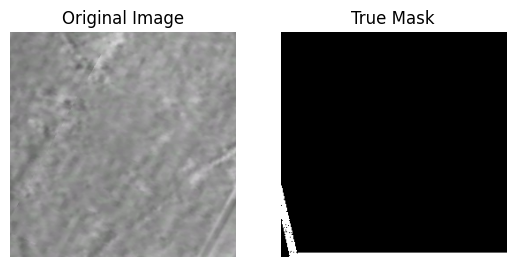

In [6]:
dataset.show(5, False)

In [7]:
model_d = DeepLab(device=device)
model_d.load('./helper/models/saved/DeepLabV3-1.pt')
model_nv = NvidiaSegformer(device=device)
model_nv.load('./helper/models/saved/NvidiaSegformer-7.pt')
model_u = UNet(device=device)
model_u.load('./helper/models/saved/UNet-2.pt')

models = [model_d, model_nv, model_u]

Initialized DeepLabV3


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Initialized NvidiaSegformer


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b1-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


Initialized UNet


In [8]:
dataset = DrainageDataset(filtered_images, filtered_masks, device=device, mode='test')
drainage_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [98]:
idx = 1000
predictions = []
image, mask = dataset[idx]
for model in models:
    predictions.append(model.predict(image, mask, device, show_full=False, show=False))

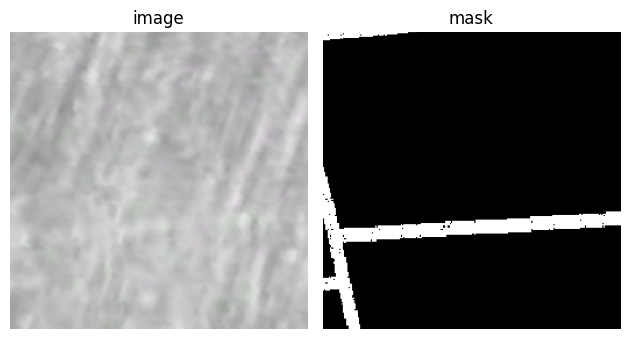

In [99]:
dataset.showitem(idx)

2 2 goida


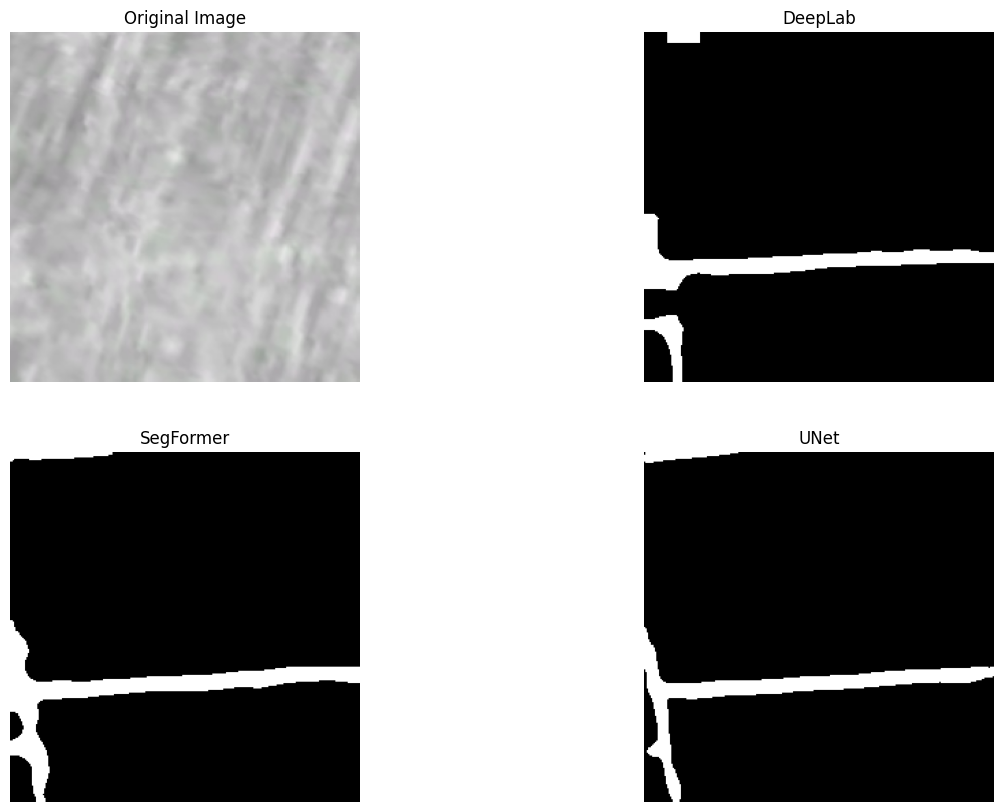

In [100]:
show_predictions(image, predictions, ['DeepLab', 'SegFormer', 'UNet'])